In [ ]:
!gdown 1PxRwOClKAwteskilx_aQekAX21GBsV56

Downloading...
From: https://drive.google.com/uc?id=1PxRwOClKAwteskilx_aQekAX21GBsV56
To: /content/StudentsPerformance.csv
100% 72.0k/72.0k [00:00<00:00, 62.1MB/s]


In [ ]:
!pip install statannot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from statannot import add_stat_annotation

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
sns.set_theme()

In [ ]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [ ]:
df.shape

(1000, 8)

# Sanity check

In [ ]:
df.isna().any()

gender                         False
race/ethnicity                 False
parental level of education    False
lunch                          False
test preparation course        False
math score                     False
reading score                  False
writing score                  False
dtype: bool

In [ ]:
df.isna().any().any()

False

Пустых значений нет

In [ ]:
df.iloc[:, :-3].apply(pd.Series.unique)

gender                                                            [female, male]
race/ethnicity                     [group B, group C, group A, group D, group E]
parental level of education    [bachelor's degree, some college, master's deg...
lunch                                                   [standard, free/reduced]
test preparation course                                        [none, completed]
dtype: object

In [ ]:
df['parental level of education'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

Категориальные признаки тоже все адекватные, гендера 2

# Посмотрим на распределения баллов

Описательные статистики:

In [ ]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [ ]:
df_scores_long = df.iloc[:, -3:].melt(var_name="subject", value_name="score")
df_scores_long.subject = df_scores_long.subject.str.split().str[0]

Сделаем ANOVA + Tukey test

In [ ]:
f_oneway(df['math score'], df['reading score'], df['writing score'])

F_onewayResult(statistic=10.824191628378626, pvalue=2.0701893192229333e-05)

p < 0.05 ==> как минимум в какой-то группе среднее отличается от остальных

In [ ]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df_scores_long['score'],
                          groups=df_scores_long['subject'],
                          alpha=0.05)
#display results
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   math reading     3.08  0.001  1.5082 4.6518   True
   math writing    1.965 0.0095  0.3932 3.5368   True
reading writing   -1.115 0.2199 -2.6868 0.4568  False
-----------------------------------------------------


Видим, что значимые различия(meandiff) наблюдаются между группами math_vs_reading(p=0.001) math_vs_writing(p=0.01), но они не особо большие


math v.s. reading: Custom statistical test, P_val:1.000e-03
reading v.s. writing: Custom statistical test, P_val:2.199e-01
math v.s. writing: Custom statistical test, P_val:9.525e-03


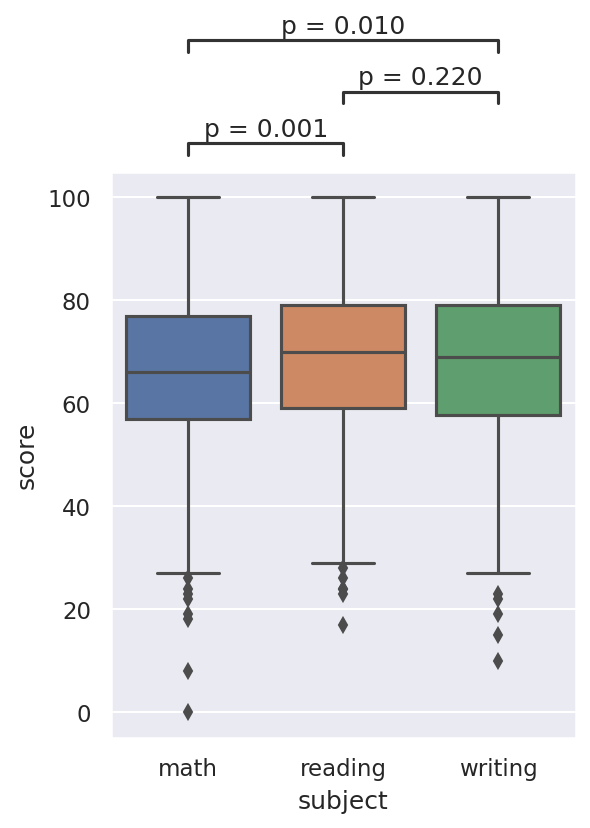

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=150)
sns.boxplot(data=df_scores_long, x='subject', y='score', ax=ax)

test_results = add_stat_annotation(ax, data=df_scores_long, x='subject', y='score',
                                   box_pairs=[("math", "reading"), ("math", "writing"), ("reading", "writing")],
                                   perform_stat_test=False, pvalues=tukey.pvalues,
                                   text_format='simple',
                                   pvalue_thresholds=[], pvalue_format_string="{:.3f}",
                                   loc='outside', verbose=2)

Некоторые наблюдения не попадают в 1.5 межквартильных размаха - отмечены черными точками, то есть у распределений длинный хвост слева:

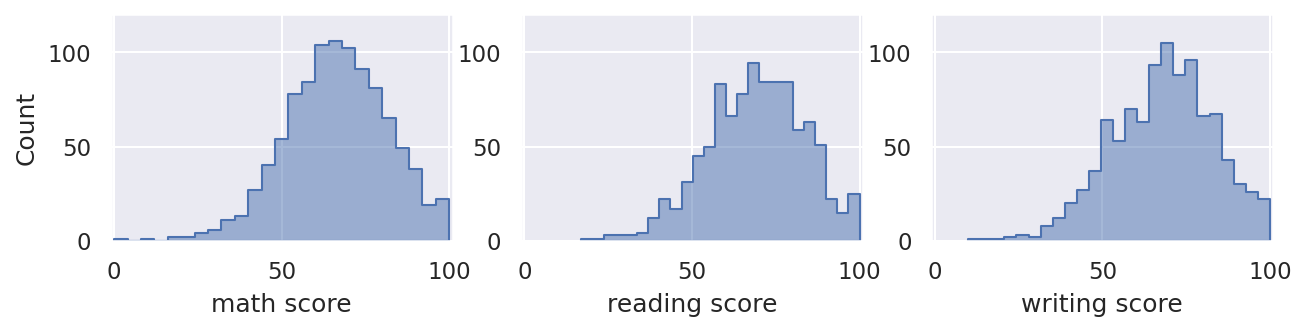

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2), dpi=150)
for i, sub in enumerate(['math score', 'reading score', 'writing score']):
    sns.histplot(data=df, x=sub, element='step', ax=ax[i], alpha=.5, bins=25)
    ax[i].set_xlim([-1, 101])
    ax[i].set_ylim([0, 120])
    if i != 0:
        ax[i].set_ylabel('')

Посмотрим, насколько баллы связаны друг с другом

In [ ]:
df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


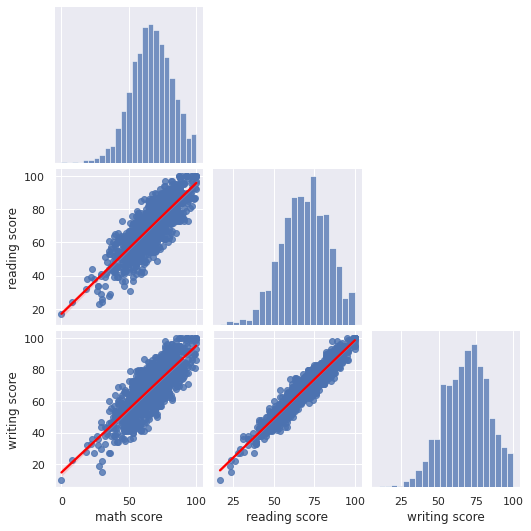

In [ ]:
sns.pairplot(df, kind='reg', corner=True, plot_kws= {'line_kws':{'color':'red'}})

Видим, что баллы довольно сильно коррелируют(особенно reading и writing), что не удивительно

Поэтому в принципе можно смотреть на сумму баллов

In [ ]:
df['sum score'] = df['math score'] + df['reading score'] + df['writing score']

In [ ]:
df.corr()['sum score']

math score       0.918746
reading score    0.970331
writing score    0.965667
sum score        1.000000
Name: sum score, dtype: float64

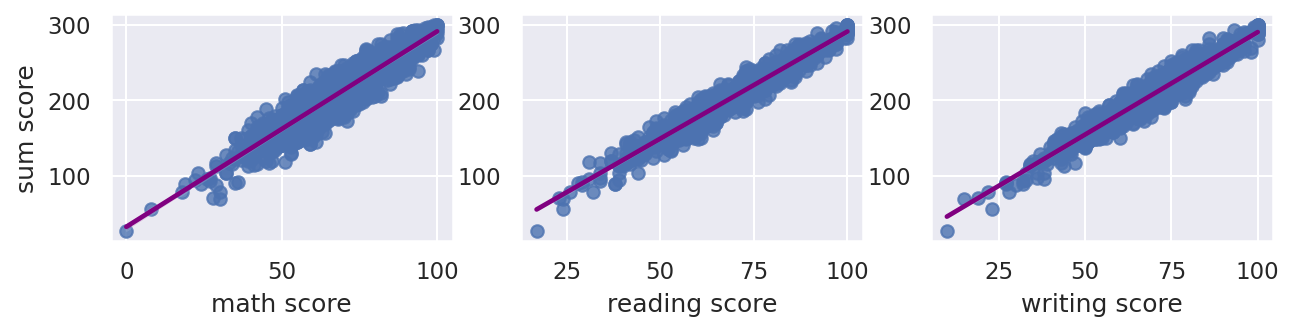

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 2), dpi=150)
for i, sub in enumerate(['math score', 'reading score', 'writing score']):
    sns.regplot(data=df, x=sub, y='sum score', ax=ax[i], line_kws={'color':'purple'})
    if i != 0:
        ax[i].set_ylabel('')

Сумма баллов также сильно коррелирует с каждым предметом по отдельности

Сделаем многофакторный ANOVA, чтобы понять, какие факторы наиболее сильно влияют на балл

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,sum score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


In [ ]:
colnames_new = [i.replace(' ', '_').replace('/', '_') for i in df.columns]
df.columns = colnames_new

In [ ]:
model_text = '+'.join(df.columns[:-4])
model_text

'gender+race_ethnicity+parental_level_of_education+lunch+test_preparation_course'

In [ ]:
model = ols(f"sum_score ~ {model_text}", data=df).fit()

In [ ]:
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
gender,1.0,3.129725e+04,31297.248063,22.305960,2.661260e-06
race_ethnicity,4.0,6.482606e+04,16206.514663,11.550596,3.614375e-09
parental_level_of_education,5.0,7.587842e+04,15175.683841,10.815909,3.821930e-10
lunch,1.0,1.519839e+05,151983.923450,108.320938,3.846022e-24
test_preparation_course,1.0,1.187781e+05,118778.101544,84.654713,2.062189e-19
Residual,987.0,1.384849e+06,1403.089063,NaN,NaN


Сделаем тест Тьюки для каждого признака:

In [ ]:
import io

In [ ]:
# perform Tukey's test
tukey_results = pd.DataFrame()
for factor in aov_table.index[:-1]:
    tukey = pairwise_tukeyhsd(endog=df['sum_score'],
                              groups=df[factor],
                              alpha=0.05)
    res = pd.read_csv(io.StringIO(tukey.summary().as_csv()), skiprows=1)
    res.columns = [i.strip() for i in res.columns]
    tukey_results = pd.concat([tukey_results, res], axis=0)
tukey_results = tukey_results.reset_index(drop=True)
tukey_results.group1 = tukey_results.group1.str.strip()
tukey_results.group2 = tukey_results.group2.str.strip()

In [ ]:
tukey_results.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,-11.1960,0.0010,-16.4649,-5.9272,True
1,group A,group B,7.4277,0.6259,-7.3486,22.2041,False
2,group A,group C,12.4175,0.1005,-1.3729,26.2079,False
3,group A,group D,18.5606,0.0031,4.4468,32.6745,True
4,group A,group E,29.2796,0.0010,13.6842,44.8750,True


Нарисуем на боксплотах только те p-value, которые < 0.05

In [ ]:
tukey_results_true = tukey_results[tukey_results.reject.str.strip() == 'True']

In [ ]:
import itertools

female v.s. male: Custom statistical test, P_val:1.000e-03
group A v.s. group D: Custom statistical test, P_val:3.100e-03
group A v.s. group E: Custom statistical test, P_val:1.000e-03
group B v.s. group D: Custom statistical test, P_val:4.450e-02
group C v.s. group E: Custom statistical test, P_val:1.000e-03
group B v.s. group E: Custom statistical test, P_val:1.000e-03
associate's degree v.s. high school: Custom statistical test, P_val:1.000e-03
master's degree v.s. high school: Custom statistical test, P_val:1.000e-03
associate's degree v.s. some high school: Custom statistical test, P_val:1.830e-02
some college v.s. high school: Custom statistical test, P_val:1.100e-03
master's degree v.s. some high school: Custom statistical test, P_val:1.000e-03
bachelor's degree v.s. high school: Custom statistical test, P_val:1.000e-03
bachelor's degree v.s. some high school: Custom statistical test, P_val:1.000e-03
standard v.s. free/reduced: Custom statistical test, P_val:1.000e-03
none v.s. 

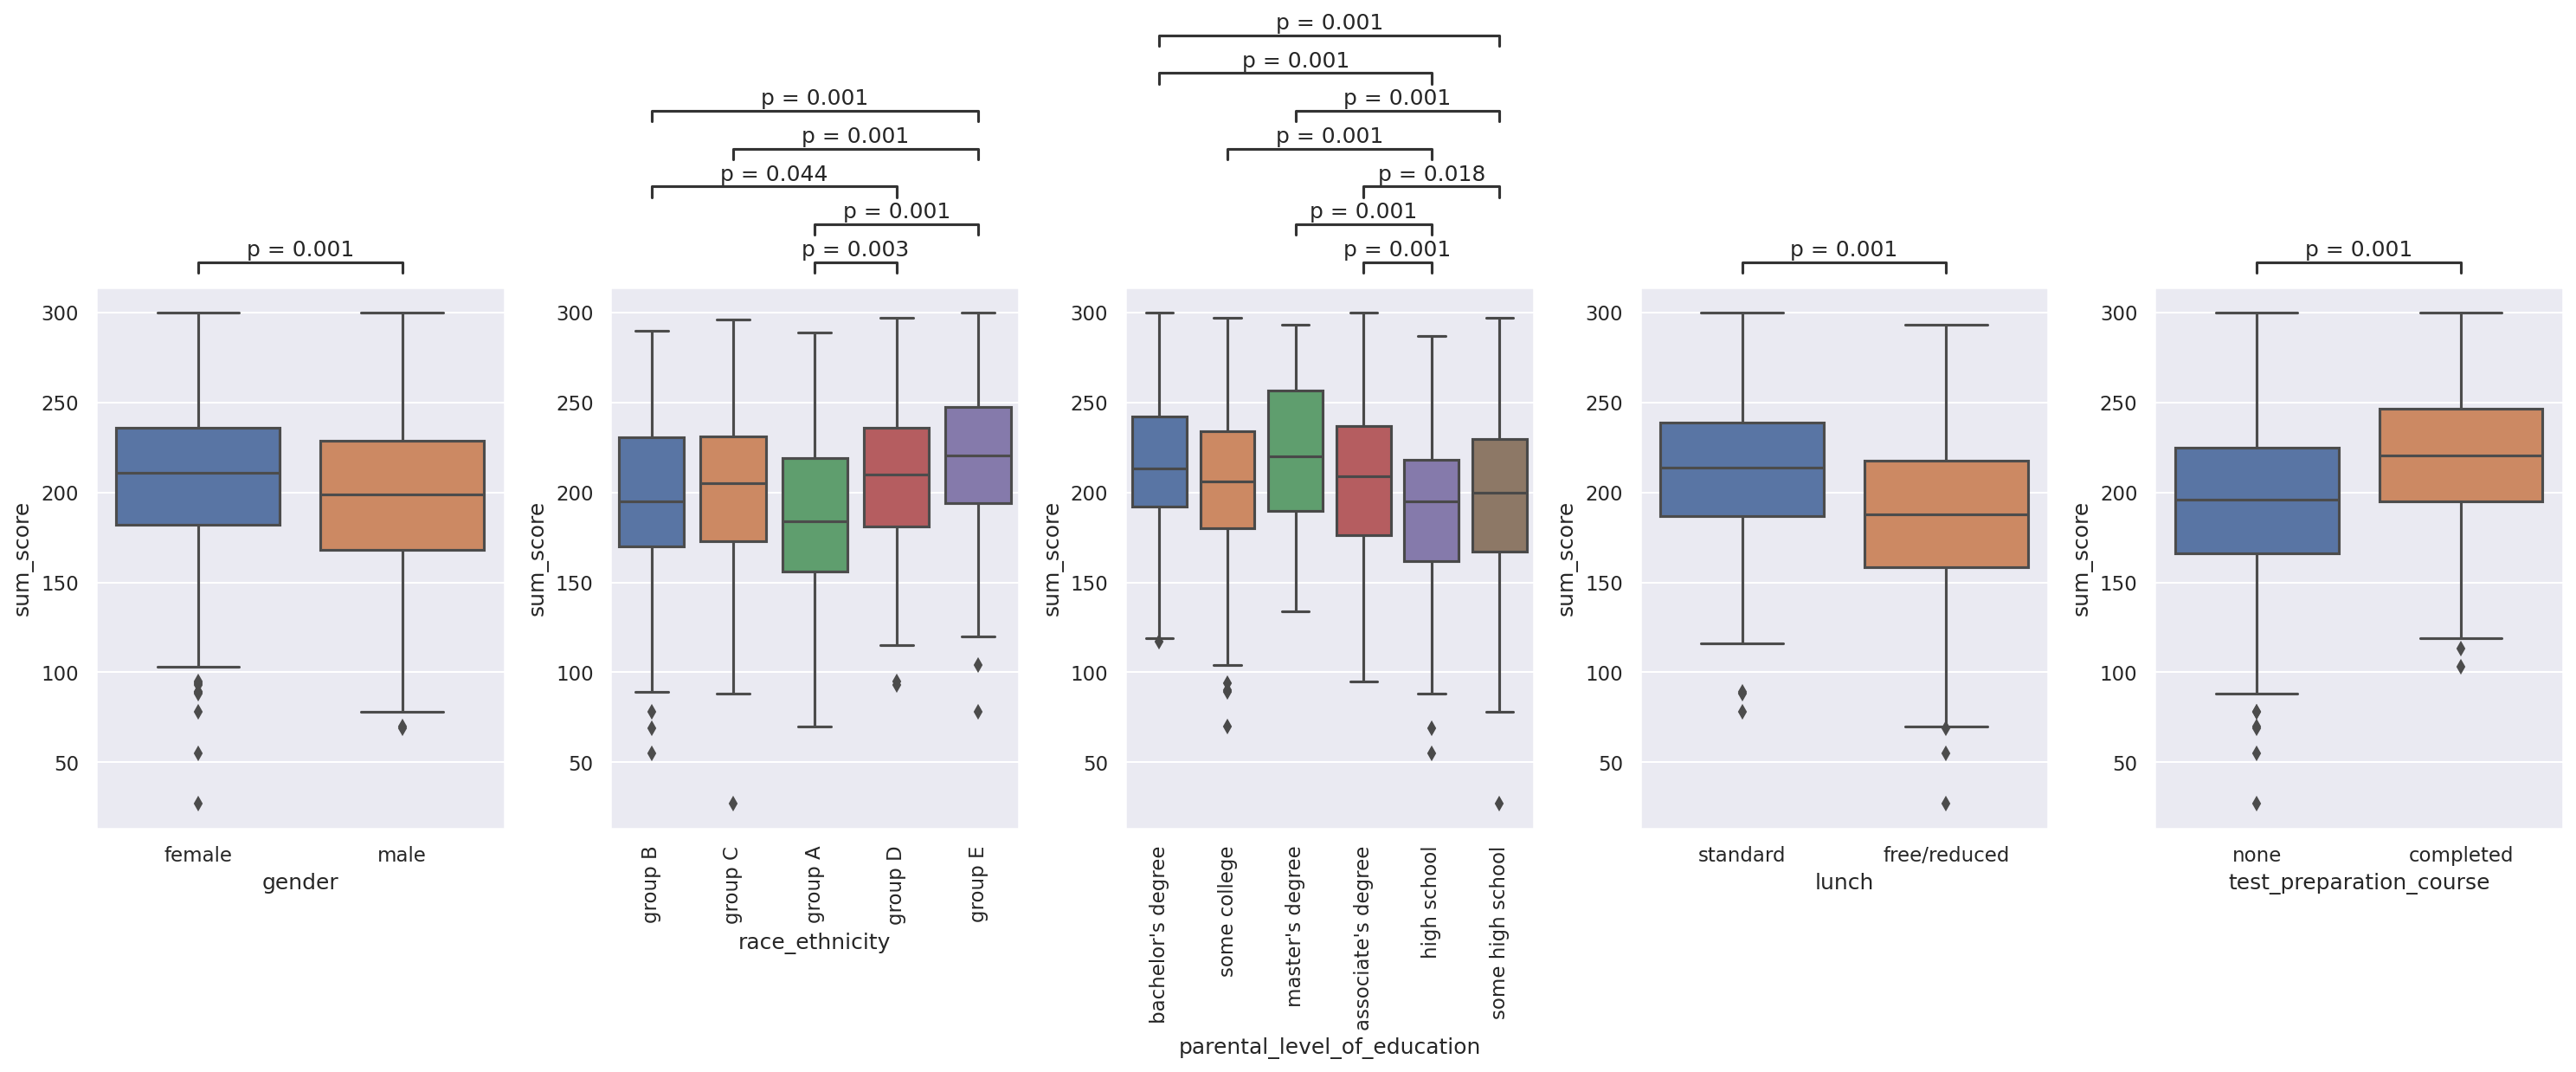

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 10), dpi=150)
for i, factor in enumerate(aov_table.index[:-1]):
    sns.boxplot(data=df, x=factor, y='sum_score', ax=ax[i])
    box_pairs = list(itertools.combinations(df[factor].unique(), 2))
    p_values = [float(tukey_results[((tukey_results.group1 == i[0]) & (tukey_results.group2 == i[1])) |
                                    ((tukey_results.group2 == i[0]) & (tukey_results.group1 == i[1]))]['p-adj'])
            for i in box_pairs]
    significant = np.where(np.array(p_values) < 0.05)[0]
    box_pairs = np.array(box_pairs)[significant]
    p_values = np.array(p_values)[significant]
    test_results = add_stat_annotation(ax[i], data=df, x=factor, y='sum_score',
                                   box_pairs=box_pairs,
                                   perform_stat_test=False, pvalues=p_values,
                                   text_format='simple',
                                   pvalue_thresholds=[], pvalue_format_string="{:.3f}",
                                   loc='outside', verbose=2)
ax[1].tick_params(axis='x', labelrotation=90)
ax[2].tick_params(axis='x', labelrotation=90)
fig.tight_layout()

In [ ]:
tukey_results.sort_values(by='meandiff', ascending=False, key=abs).head(10)

,group1,group2,meandiff,p-adj,lower,upper,reject
20,high school,master's degree,31.5058,0.0010,13.7977,49.2139,True
4,group A,group E,29.2796,0.0010,13.6842,44.8750,True
16,bachelor's degree,high school,-26.4804,0.0010,-40.3751,-12.5856,True
26,free/reduced,standard,25.9144,0.0010,20.6035,31.2254,True
24,master's degree,some high school,-25.4726,0.0010,-43.3741,-7.5710,True
27,completed,none,-22.8916,0.0010,-28.2451,-17.5380,True
7,group B,group E,21.8519,0.0010,9.0388,34.6650,True
19,bachelor's degree,some high school,-20.4472,0.0010,-34.5877,-6.3066,True
12,associate's degree,high school,-19.4164,0.0010,-31.1043,-7.7284,True
3,group A,group D,18.5606,0.0031,4.4468,32.6745,True


Самые сильные средние различия наблюдаются в группах:  parental level of education, race/ethnicity

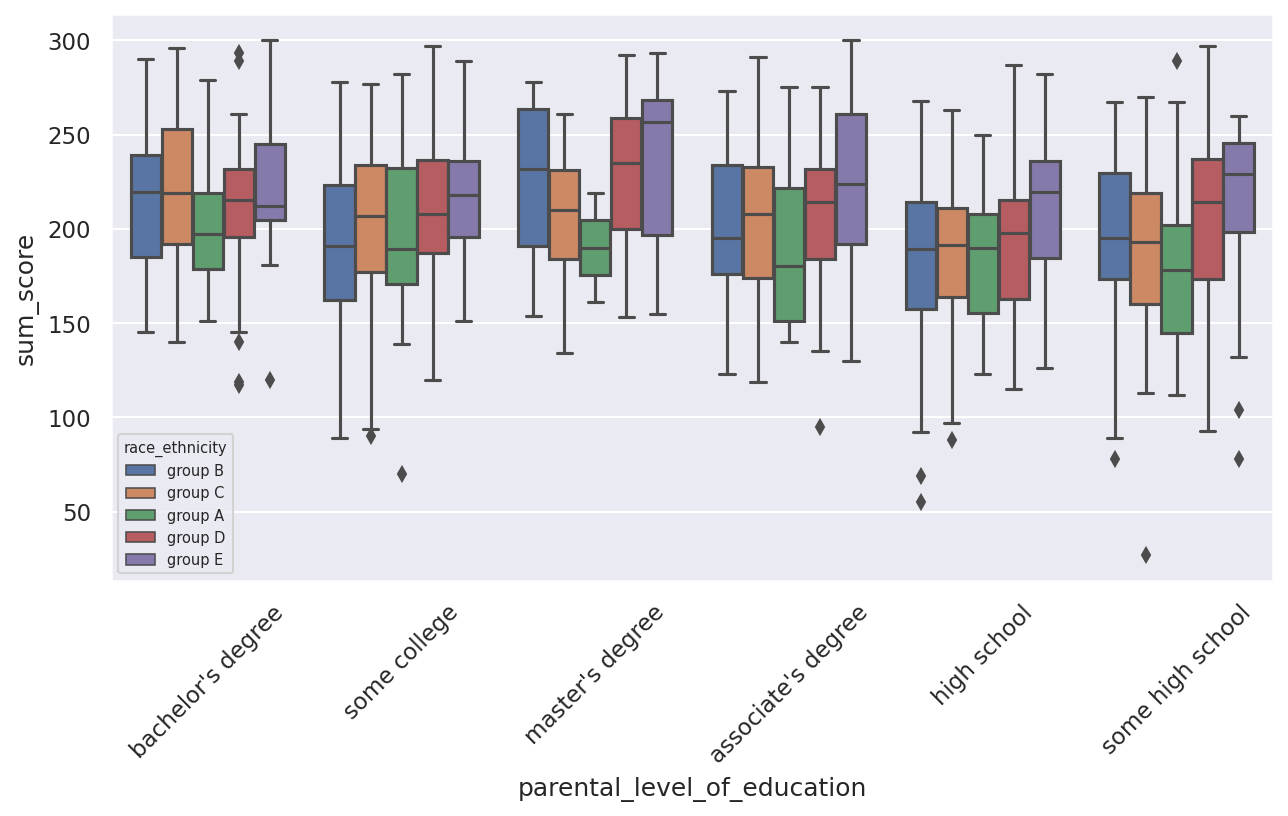

In [ ]:
plt.figure(figsize=(10, 5), dpi=150)
ax = sns.boxplot(data=df, x='parental_level_of_education', y='sum_score', hue='race_ethnicity')
sns.move_legend(ax, 'lower left', fontsize=7, title_fontsize=7)
ax.tick_params(axis='x', labelrotation=45)

Видно, что почти во всех группах по образованию родителей самая умная раса - group E

In [ ]:
df.groupby(['parental_level_of_education', 'race_ethnicity']).sum_score.mean()

parental_level_of_education  race_ethnicity
associate's degree           group A           191.642857
                             group B           203.926829
                             group C           208.128205
                             group D           208.000000
                             group E           221.923077
bachelor's degree            group A           203.583333
                             group B           213.900000
                             group C           219.725000
                             group D           209.607143
                             group E           226.777778
high school                  group A           183.833333
                             group B           184.500000
                             group C           186.984375
                             group D           190.431818
                             group E           208.636364
master's degree              group A           190.000000
                            

# Попробуем предсказать cумму баллов по категориальным признакам

In [ ]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,sum_score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X = df.iloc[:, :-4]
y = df.iloc[:, -1]

In [ ]:
enc = OneHotEncoder()
enc.fit(X)
X = enc.transform(X)

In [ ]:
enc.categories_

[array(['female', 'male'], dtype=object),
 array(['group A', 'group B', 'group C', 'group D', 'group E'],
       dtype=object),
 array(["associate's degree", "bachelor's degree", 'high school',
        "master's degree", 'some college', 'some high school'],
       dtype=object),
 array(['free/reduced', 'standard'], dtype=object),
 array(['completed', 'none'], dtype=object)]

In [ ]:
X.A

array([[1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X.A.shape

(1000, 17)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

scores = []
for max_d in range(2, 101):
    reg = DecisionTreeRegressor(criterion='squared_error', max_depth=max_d, random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    sc = mean_squared_error(y_test, y_pred)
    scores.append(sc)

Text(0, 0.5, 'rmse')

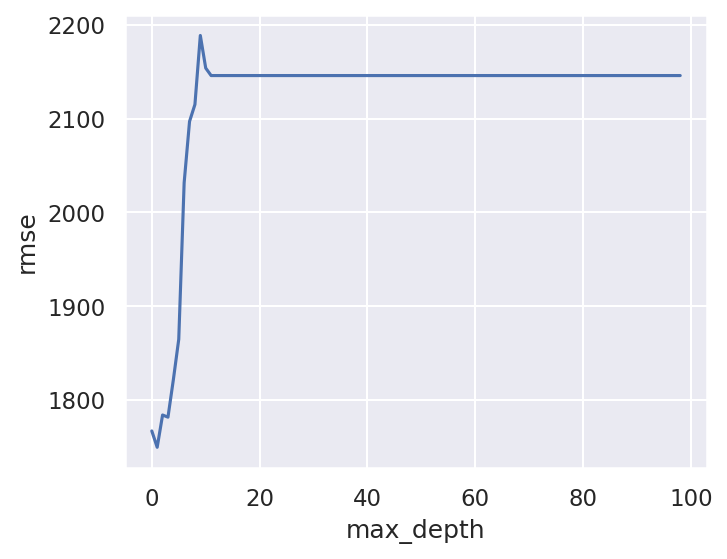

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.plot(scores)
ax.set_xlabel('max_depth')
ax.set_ylabel('rmse')

In [ ]:
np.argmin(scores)

1

Т.е. лучше всего справляется дерево с max_depth=3

In [ ]:
reg = DecisionTreeRegressor(criterion='squared_error', max_depth=3, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

1750.0483049010168

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

41.83357867671635

Хотя все равно сильно ошибается на 40 баллов - такое себе

[Text(0.5, 0.875, 'X[14] <= 0.5\nsquared_error = 1730.43\nsamples = 700\nvalue = 205.121'),
 Text(0.25, 0.625, 'X[16] <= 0.5\nsquared_error = 1719.473\nsamples = 241\nvalue = 188.386'),
 Text(0.125, 0.375, 'X[7] <= 0.5\nsquared_error = 1571.361\nsamples = 91\nvalue = 205.154'),
 Text(0.0625, 0.125, 'squared_error = 1470.188\nsamples = 68\nvalue = 200.441'),
 Text(0.1875, 0.125, 'squared_error = 1610.688\nsamples = 23\nvalue = 219.087'),
 Text(0.375, 0.375, 'X[8] <= 0.5\nsquared_error = 1535.274\nsamples = 150\nvalue = 178.213'),
 Text(0.3125, 0.125, 'squared_error = 1522.429\nsamples = 128\nvalue = 175.023'),
 Text(0.4375, 0.125, 'squared_error = 1206.357\nsamples = 22\nvalue = 196.773'),
 Text(0.75, 0.625, 'X[15] <= 0.5\nsquared_error = 1511.913\nsamples = 459\nvalue = 213.908'),
 Text(0.625, 0.375, 'X[1] <= 0.5\nsquared_error = 1492.608\nsamples = 302\nvalue = 206.576'),
 Text(0.5625, 0.125, 'squared_error = 1429.882\nsamples = 164\nvalue = 214.451'),
 Text(0.6875, 0.125, 'squared_er

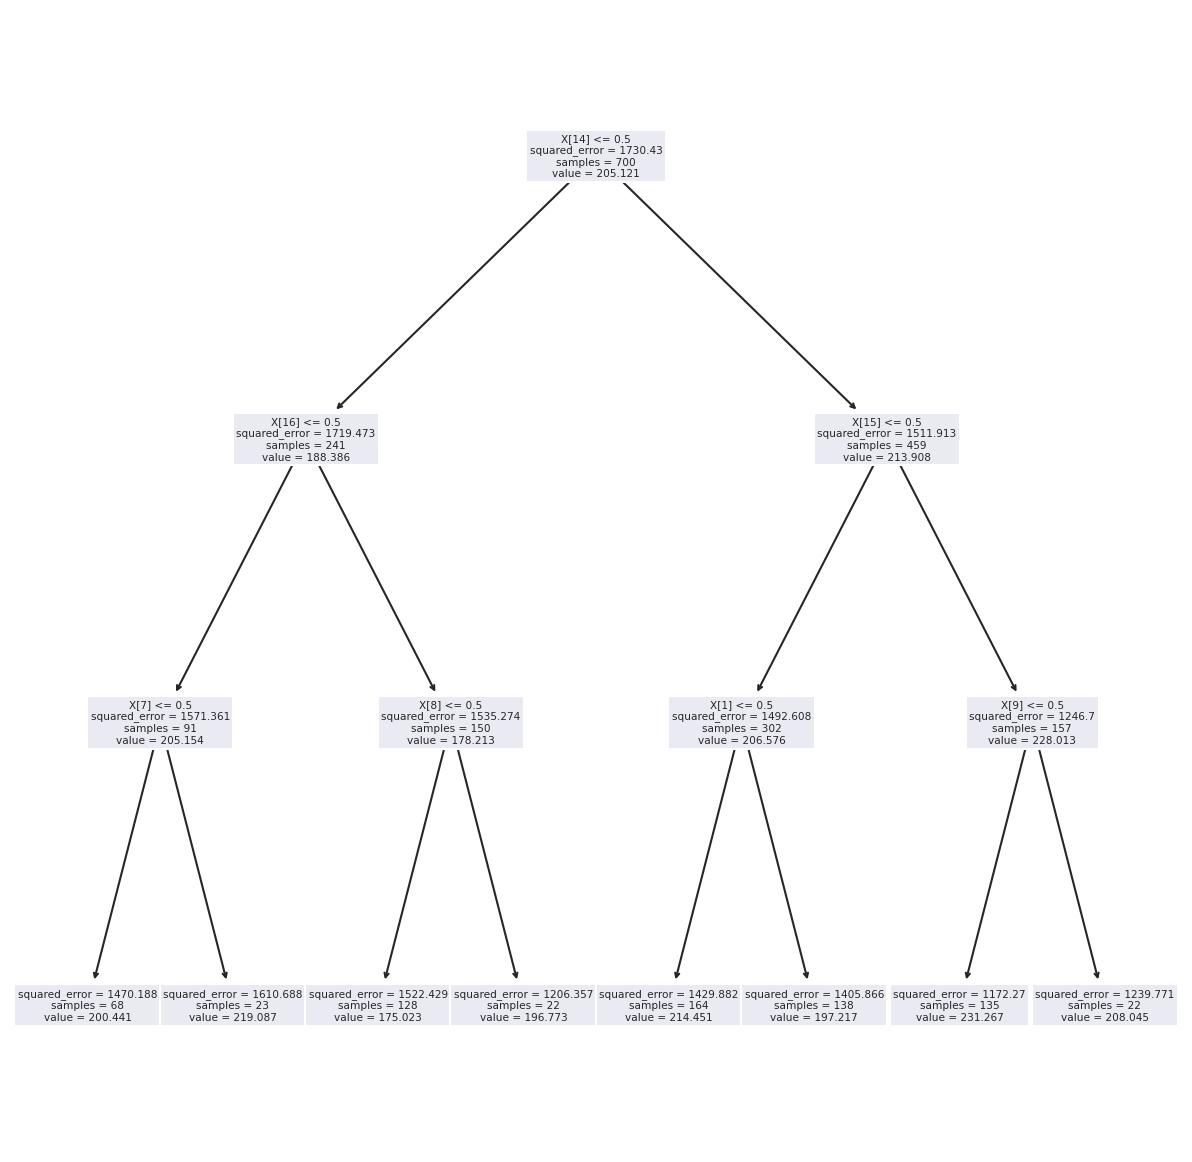

In [ ]:
plt.figure(figsize=(10, 10), dpi=150)
from sklearn.tree import plot_tree
plot_tree(reg)

In [ ]:
for i in [14, 16, 15, 7, 8, 1, 9]:
    print(np.hstack(enc.categories_)[i])

standard
none
completed
associate's degree
bachelor's degree
male
high school
